# Inaugural Project

Imports and set magics:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import warnings

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
from  inauguralproject import HouseholdSpecializationModelClass

# Question 1

c:\Users\mauri\OneDrive\Área de Trabalho\University of Copenhagen\Second Semester\Introduction to Programing and Numerical Analysis\projects-2023-it-hurts-when-ip\inauguralproject\inauguralproject.py:61: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma) + par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


Text(0.5, 1.0, 'Ratio of HF to HM')

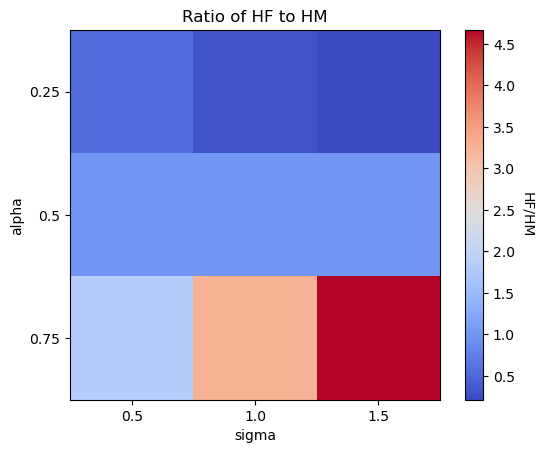

In [21]:
#To solve the first question we need to adapt the original code to also include the situations when sigma!=1.0, this is implemented on the 
#section # b. home production of def calc_utility(self,LM,HM,LF,HF) inside of the inauguralproject.py 
# initialize model
model = HouseholdSpecializationModelClass()

# values of alpha and sigma to investigate
alpha_vals = [0.25, 0.5, 0.75]
sigma_vals = [0.5, 1.0, 1.5]

# initialize array to store ratios
ratios = np.zeros((len(alpha_vals), len(sigma_vals)))

# loop over alpha and sigma values
for i, alpha in enumerate(alpha_vals):
    for j, sigma in enumerate(sigma_vals):
        
        # set alpha and sigma in the model
        model.par.alpha = alpha
        model.par.sigma = sigma
        
        # solve the model
        opt = model.solve_discrete()
        
        # calculate ratio
        ratio = opt.HF / opt.HM
        ratios[i, j] = ratio

# plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(ratios, cmap='coolwarm')

# set tick labels
ax.set_xticks(np.arange(len(sigma_vals)))
ax.set_yticks(np.arange(len(alpha_vals)))
ax.set_xticklabels(sigma_vals)
ax.set_yticklabels(alpha_vals)

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('HF/HM', rotation=-90, va="bottom")

# add axis labels
ax.set_xlabel('sigma')
ax.set_ylabel('alpha')

# set title
ax.set_title('Ratio of HF to HM')


The resulting illustration is a heatmap that shows the ratio of female-to-male household production (HF/HM) for different values of alpha and sigma. By analyzing the heatmap, is possible to observe that for higher values of sigma when alpha = 0.75, the ratio of HF (female household production) to HM (male household production) is higher. This means that female household production is relatively more important in these cases. On the other hand, for lower values of alpha, the ratio of HF to HM is lower, indicating that male household production is relatively more important, with changes in sigma being insignificant when alpha = 0.5 and an increase in sigma decreases HF/HM ratio when alpha = 0.25.

# Question 2

 To plot $\log\frac{H_{F}}{H_{M}}$ against $\log\frac{w_{F}}{w_{M}}$ for $w_{F}\in[0.8,0.9,1.0,1.1,1.2]$, we first need to solve the model for each value of $w_F$ in the range. We can do this using the solve_wF_vec method of the HouseholdSpecializationModelClass, that has also been added in the inauguralproject.py, with the discrete parameter set to true:

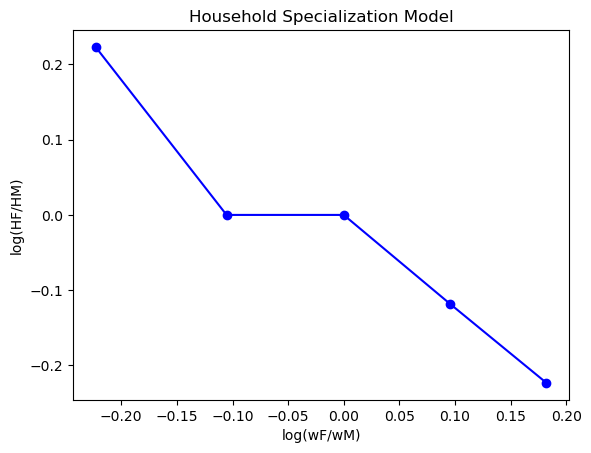

In [29]:
# To plot $\log\frac{H_{F}}{H_{M}}$ against $\log\frac{w_{F}}{w_{M}}$ for $w_{F}\in[0.8,0.9,1.0,1.1,1.2]$, 
# we first need to solve the model for each value of $w_F$ in the range. We can do this using the solve_wF_vec method of 
# the HouseholdSpecializationModelClass, that has also been added in the inauguralproject.py, with the discrete parameter set to true:

# set wF_vec
model.par.wF_vec = np.array([0.8, 0.9, 1.0, 1.1, 1.2])

# solve model for each value of wF
model.solve_wF_vec(discrete=True)

# calculate log(HF/HM) and log(wF/wM)
log_HFHM = np.log(model.sol.HF_vec/model.sol.HM_vec)
log_wFwM = np.log(model.par.wF_vec/model.par.wM)

# create plot
plt.plot(log_wFwM, log_HFHM, 'bo-')
plt.xlabel('log(wF/wM)')
plt.ylabel('log(HF/HM)')
plt.title('Household Specialization Model')
plt.show()

As is possible to visualize, as women's wages increase in relation to men's wages, women spend less time working at home, as their time can be more productive in the market.

# Question 3

 To plot $\log\frac{H_{F}}{H_{M}}$ against $\log\frac{w_{F}}{w_{M}}$ for $w_{F}\in[0.8,0.9,1.0,1.1,1.2]$ (model.par.wF_vec was stated in the previous question), we, again, first need to solve the model for each value of $w_F$ in the range. Using the same approach as the previous question, but this time with the discrete parameter set to false, so the model will be solved using the continuous method.

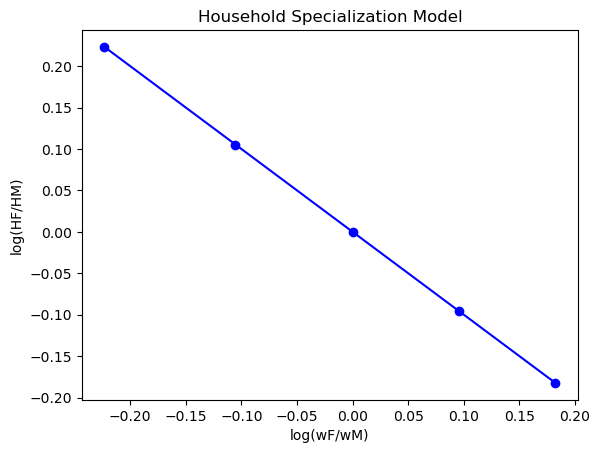

In [30]:

# solve model for each value of wF
model.solve_wF_vec(discrete=False)

# calculate log(HF/HM) and log(wF/wM)
log_HFHM = np.log(model.sol.HF_vec/model.sol.HM_vec)
log_wFwM = np.log(model.par.wF_vec/model.par.wM)

# create plot
plt.plot(log_wFwM, log_HFHM, 'bo-')
plt.xlabel('log(wF/wM)')
plt.ylabel('log(HF/HM)')
plt.title('Household Specialization Model')
plt.show()


When discrete=False, the solve_wF_vec method solves the model for a continuous range of values of wF, rather than a discrete set of values. This results in a smoother curve in the plot, when comparing to the previous plot. Obtaining the same interpretation as the previous question.

# Question 4

In [17]:
model2 = HouseholdSpecializationModelClass()

In [18]:
def obj(x):
    model2.par.alpha = x[0]
    model2.par.sigma = x[1]

    model2.solve_wF_vec()
    model2.run_regression()
    beta0_hat = model2.sol.beta0
    beta1_hat = model2.sol.beta1
    
    return (0.4 - beta0_hat)**2 + (-0.1 - beta1_hat)**2 

In [19]:
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

bounds = [(0.8,0.99), (0.02, 0.20)]
res = optimize.minimize(obj, (0.9,0.15), method='Nelder-Mead', bounds=bounds)

print('To achieve beta0 = 0.4 and beta1 = -0.1,')
print(f'alpha = {res.x[0]:5.4f}')
print(f'sigma = {res.x[1]:5.4f}')

To achieve beta0 = 0.4 and beta1 = -0.1,
alpha = 0.9820
sigma = 0.1000


In [33]:
model2.par.sigma = 1
model2.par.alpha = 0.98
print(model2.solve())


namespace(LM=7.102059260859654, HM=0.1776258535871508, LF=1.482634473296534, HF=7.252992368134714)


To fit the data, we need to have a high value for alpha and a low value for sigma.

$α/(1-α)$ is the productivity in home production for females relative to males, therefore to fit the data women must be significantly more productive than men in the home. The low value of sigma means that there is a low elasticity of substitution between men and women at home. 

As illustrated below, under the assumption that they both work for 8 hours, the women have a significantly higher level of productivity when working at home, in accordance with the model. Hence, it is both economically and econometrically consistent, for the given the true parameter values, that the women should be working more hours in the home whilst the men should be investing their work hours mainly in the labour market.
 

In [35]:
sig = 0.1
alpha = 0.9820
mh = 8
wh = 8

man = (1-alpha)*(mh ** (sig-1)/sig)
wom = (alpha)*(wh ** (sig-1)/sig)

print(man, wom)

0.02770074930026064 1.5112297673808848


# Question 5

Our findings so far, however, are far from realistic given the gaping chasm of difference between the productivity of men and women at home, as evident by the acquired value of alpha. This leaves room for improvement in the model to better reflect the real world.

In [39]:
model2 = HouseholdSpecializationModelClass()

model2.par.alpha = 0.98
model2.par.sigma = 0.1

model2.solve_wF_vec()

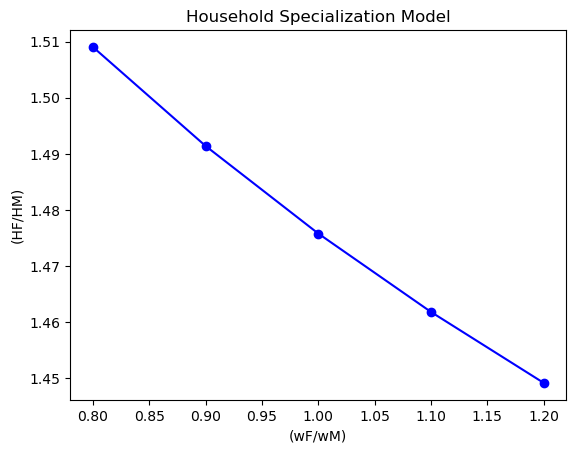

In [43]:
# calculate log(HF/HM) and log(wF/wM)
log_HFHM = (model2.sol.HF_vec/model2.sol.HM_vec)
log_wFwM = (model2.par.wF_vec/model2.par.wM)

# create plot
plt.plot(log_wFwM, log_HFHM, 'bo-')
plt.xlabel('(wF/wM)')
plt.ylabel('(HF/HM)')
plt.title('Household Specialization Model')
plt.show()

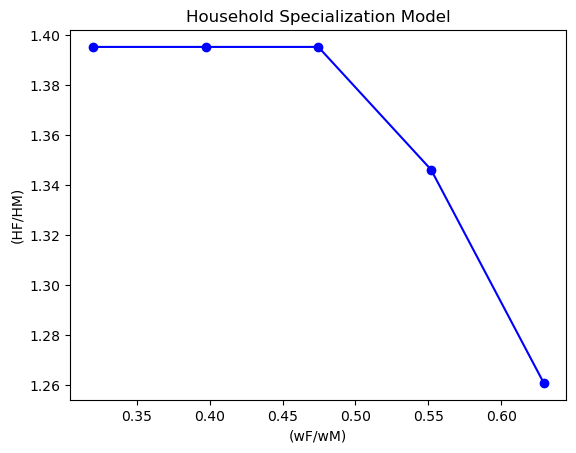

0.2032602295681804
-0.13248401842803625


In [56]:
model2 = HouseholdSpecializationModelClass()
model2.par.wF_vec=np.linspace(0.32,0.629,num=5)
model2.par.alpha = 0.5
model2.par.sigma = 0.5
model2.solve_wF_vec()


log_HFHM = (model2.sol.HF_vec/model2.sol.HM_vec)
log_wFwM = (model2.par.wF_vec/model2.par.wM)

# create plot
plt.plot(log_wFwM, log_HFHM, 'bo-')
plt.xlabel('(wF/wM)')
plt.ylabel('(HF/HM)')
plt.title('Household Specialization Model')
plt.show()

model2.run_regression()
print(model2.sol.beta0)
print(model2.sol.beta1)

In [47]:
model2.run_regression()
print(model2.sol.beta0)
print(model2.sol.beta1)

0.050667872678810635
-0.7897519678528262


ADD CONCISE CONLUSION.